In [1]:
import numpy as np
import collections
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
from mydefaults import mydefaults
import numpy as np
import matplotlib.pyplot as plt
from fABBA import fABBA

def symbolsAssign(clusters, alphabet_set=0):
    """ automatically assign symbols to different clusters, start with '!'
    
    Parameters
    ----------
    clusters - list or pd.Series or array
        The list of clusters.

    alphabet_set - int or list
        The letter set to be used

        
    ----------
    Return:
    
    symbols(list of string), inverse_hash(dict): repectively for the
    corresponding symbolic sequence and the hashmap for inverse transform.
    
    """
    
    clusters = pd.Series(clusters)
    N = len(clusters.unique())
    
    if alphabet_set == 0:
        alphabets = ['A','a','B','b','C','c','D','d','E','e',
                    'F','f','G','g','H','h','I','i','J','j',
                    'K','k','L','l','M','m','N','n','O','o',
                    'P','p','Q','q','R','r','S','s','T','t',
                    'U','u','V','v','W','w','X','x','Y','y','Z','z']
    
    elif alphabet_set == 1:
        alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                    'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 
                    'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
                    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 
                    'w', 'x', 'y', 'z']
    
    elif isinstance(alphabet_set, list):
        if N <= len(alphabet_set):
            alphabets = alphabet_set
        else:
            raise ValueError("Please ensure the length of ``alphabet_set`` is greatere than ``clusters``.")
       
    else:
        alphabets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                    'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 
                    'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
                    'W', 'X', 'Y', 'Z']
        


    cluster_sort = [0] * N 
    counter = collections.Counter(clusters)
    for ind, el in enumerate(counter.most_common()):
        cluster_sort[ind] = el[0]

    if N >= len(alphabets):
        alphabets = [chr(i+33) for i in range(0, N)]
    else:
        alphabets = alphabets[:N]
        
    hashm = dict(zip(cluster_sort + alphabets, alphabets + cluster_sort))
    strings = [hashm[i] for i in clusters]
    return strings, hashm



class SAX:
    def __init__(self, *, width=2, n_paa_segments=None, k=5, return_list=False, verbose=True):
        if n_paa_segments is not None:
            # if verbose == True:
                # warnings.warn("Set width to ``len(ts) // n_paa_segments''")
            self.n_paa_segments = n_paa_segments
            self.width = None 
        else:
            self.n_paa_segments = None
            self.width = width

        self.verbose = verbose
        self.breakpoints = None
        self.breakpoint_values = None

        self.num_of_symbols = k
        self.return_list = return_list
        self.mu, self.std = 0, 1
        

    def fit_transform(self, ts):
        return self.fit(ts)

    
    def fit(self, ts):
        if self.width is None:
            self.width = len(ts) // self.n_paa_segments
            
        self.mu = np.mean(ts)
        self.std = np.std(ts)

        if self.std == 0:
            self.std = 1

        ts = (ts - self.mu)/self.std
        compressed_ts = self.paa_mean(ts)
        symbolic_ts = self._digitize(compressed_ts)
        if self.verbose:
            print("Compress {0} time series points into {1} pieces and {2} symbols.".format(
                len(ts), len(compressed_ts), self.num_of_symbols
            ))


        return symbolic_ts


    def transform(self, ts):
        ts = (ts - self.mu)/self.std
        compressed_ts = self.paa_mean(ts)
        symbolic_ts = self._digitize(compressed_ts)
        return symbolic_ts

    
    def inverse_transform(self, symbolic_ts):
        compressed_ts = self._reverse_digitize(symbolic_ts)
        ts = self._reconstruct(compressed_ts)
        ts = ts*self.std + self.mu
        return ts

    
    def paa_mean(self, ts):
        if len(ts) % self.width != 0:
            warnings.warn("Result truncates, width does not divide length")
        return [np.mean(
            ts[i*self.width:np.min([len(ts), (i+1)*self.width])]
            ) for i in range(int(np.floor(len(ts)/self.width)))]

    
    def _digitize(self, ts):
        symbolic_ts = self._gaussian_breakpoints(ts)
        return symbolic_ts

    
    def _gaussian_breakpoints(self, ts):
        # Construct Breakpoints
        if self.breakpoints is None:
            self.breakpoints = self.breakpoints_build(self.num_of_symbols)
        
        labels = []
        for i in ts:
            for j in range(len(self.breakpoints)):
                if i < self.breakpoints[j]:
                    labels.append(j)
                    break

        strings, self.hashm = symbolsAssign(labels)
        if not self.return_list:
            strings = "".join(strings)

        return strings

    
    def _reconstruct(self, reduced_ts):
        return self._reverse_pca(reduced_ts)
    
    
    def _reverse_pca(self, ts):
        return np.kron(ts, np.ones([1,self.width])[0])

    
    def _reverse_digitize(self, symbolic_ts):
        return self._reverse_gaussian_breakpoints(symbolic_ts)
    
    
    def _reverse_gaussian_breakpoints(self, symbols):
        if self.breakpoint_values is None:
            self.breakpoint_values = self.breakpoint_values_build(self.num_of_symbols)

        ts = []
        for s in symbols:
            j = self.hashm[s]
            ts.append(self.breakpoint_values[j])
        return ts
    
    def breakpoints_build(self, num_of_symbols):
        return np.hstack(
            (norm.ppf([float(a) / num_of_symbols for a in range(1, num_of_symbols)], scale=1), 
             np.inf))
    
    def breakpoint_values_build(self, num_of_symbols):
        return norm.ppf(
                [float(a) / (2 * num_of_symbols) for a in range(1, 2 * num_of_symbols, 2)], scale=1)



In [7]:
def loadUCR(filename='ECG200', num=1, type='TEST'):
    df = pd.read_csv('UCR2018/'+filename+'/'+filename+'_'+type+'.tsv', sep='\t', header=None)
    return df.iloc[num, 1:].values

ts = [np.sin(0.05*i) for i in range(1000)]  # original time series

In [8]:
fabba = fABBA(tol=0.1, alpha=0.1, sorting='2-norm', scl=1, verbose=0)

symbols_fabba = fabba.fit_transform(ts)
print('fABBA:', symbols_fabba, len(symbols_fabba))                              
ts_fabba = fabba.inverse_transform(symbols_fabba, ts[0]) 

sax = SAX(n_paa_segments=len(symbols_fabba)+3, k=fabba.parameters.centers.shape[0])
symbols_sax = sax.fit_transform(ts)
print('SAX:', symbols_sax, len(symbols_sax))     
ts_SAX = sax.inverse_transform(symbols_sax)

fABBA: aBbCbCbCbCbCbCbCA 17
Compress 1000 time series points into 20 pieces and 5 symbols.
SAX: aACBbaACBbaACBbaAABb 20


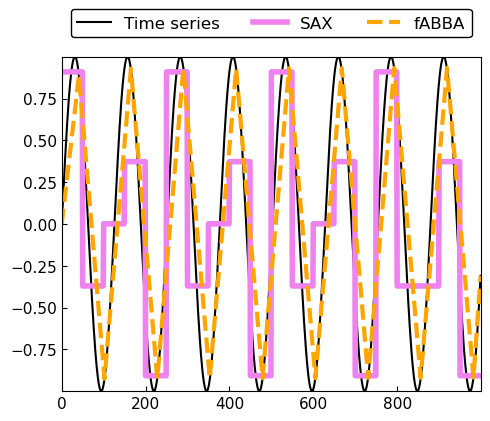

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
fig, ax = mydefaults(fig, ax)

ax.plot(ts, c='k', label='Original')
ax.plot(ts_SAX, linestyle='-', color='violet', linewidth=4, label='SAX')
ax.plot(ts_fabba, '--',  color='orange', linewidth=3, label='fABBA')
ax.legend(labels=['Time series', 'SAX', 'fABBA'], fontsize=12, loc='center', ncols=3, bbox_to_anchor=(0.5, 1.1))
# ax[0].legend(fontsize=12, loc='upper center', ncols=2, bbox_to_anchor=(0.5, 1.05))
# plt.grid(False) # axis='y'
# plt.tick_params(axis='both', labelsize=14)
plt.savefig('results/SINE.pdf', bbox_inches='tight')
# need_to_plot = False

In [16]:

ts = loadUCR(filename='ECGFiveDays', num=1, type='TEST')

fabba = fABBA(tol=0.1, alpha=0.1, sorting='2-norm', scl=1, verbose=0)

symbols_fabba = fabba.fit_transform(ts)
print('fABBA:', symbols_fabba, len(symbols_fabba))                                        
ts_fabba = fabba.inverse_transform(symbols_fabba, ts[0]) 

sax = SAX(n_paa_segments=len(symbols_fabba)+4, k=fabba.parameters.centers.shape[0])
symbols_sax = sax.fit_transform(ts)
print('SAX:', symbols_sax, len(symbols_sax))            
ts_SAX = sax.inverse_transform(symbols_sax)

fABBA: fAcaDECeBdbF 12
Compress 136 time series points into 17 pieces and 12 symbols.
SAX: AAAAAABbCcDaaaAaa 17


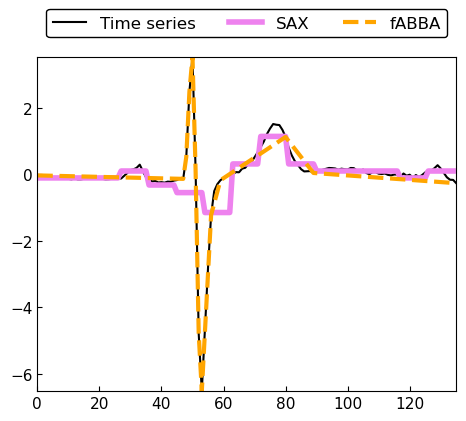

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
fig, ax = mydefaults(fig, ax)

ax.plot(ts, c='k', label='Original')
ax.plot(ts_SAX, linestyle='-', color='violet', linewidth=4, label='SAX')
ax.plot(ts_fabba, '--',  color='orange', linewidth=3, label='fABBA')
ax.legend(labels=['Time series', 'SAX', 'fABBA'], fontsize=12, loc='center', ncols=3, bbox_to_anchor=(0.5, 1.1))
# ax[0].legend(fontsize=12, loc='upper center', ncols=2, bbox_to_anchor=(0.5, 1.05))
# plt.grid(False) # axis='y'
# plt.tick_params(axis='both', labelsize=14)
plt.savefig('results/ECGFiveDays.pdf', bbox_inches='tight')
# need_to_plot = False